In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, classification_report,
                             roc_auc_score, roc_curve)
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

In [2]:
# Set parameters for synthetic data
n_employees = 1500
departments = ['Sales', 'Engineering', 'HR', 'Finance', 'Marketing']
salary_levels = ['low', 'medium', 'high']

# Generate synthetic data
data = {
    'age': np.random.randint(22, 65, size=n_employees),
    'department': np.random.choice(departments, size=n_employees, p=[0.3, 0.2, 0.1, 0.2, 0.2]),
    'salary': np.random.choice(salary_levels, size=n_employees, p=[0.5, 0.3, 0.2]),
    'satisfaction': np.round(np.random.uniform(0.1, 1.0, size=n_employees), 2),
    'evaluation': np.round(np.random.uniform(0.3, 1.0, size=n_employees), 2),
    'projects': np.random.randint(1, 8, size=n_employees),
    'avg_monthly_hours': np.random.randint(120, 350, size=n_employees),
    'tenure': np.random.randint(1, 11, size=n_employees),
    'work_accident': np.random.choice([0, 1], size=n_employees, p=[0.9, 0.1]),
    'promotion': np.random.choice([0, 1], size=n_employees, p=[0.95, 0.05]),
    'left': np.random.choice([0, 1], size=n_employees, p=[0.8, 0.2])  # 20% turnover rate
}

# Create DataFrame
df = pd.DataFrame(data)

# Add some missing values (3% of each column)
for col in df.columns:
    df.loc[df.sample(frac=0.03).index, col] = np.nan

# Display the first few rows
df.head()

,age,department,salary,satisfaction,evaluation,projects,avg_monthly_hours,tenure,work_accident,promotion,left
0,60.0,Marketing,low,0.68,0.49,3.0,225.0,2.0,0.0,0.0,0.0
1,NaN,Finance,high,0.19,0.32,7.0,258.0,4.0,NaN,NaN,0.0
2,36.0,Finance,medium,0.46,NaN,6.0,340.0,9.0,0.0,0.0,1.0
3,64.0,Marketing,NaN,0.76,0.74,6.0,136.0,2.0,0.0,0.0,0.0
4,29.0,Marketing,low,0.80,0.71,5.0,273.0,4.0,0.0,0.0,0.0


In [3]:
# Basic information about the dataset
print("Dataset Info:")
df.info()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                1455 non-null   float64
 1   department         1455 non-null   object 
 2   salary             1455 non-null   object 
 3   satisfaction       1455 non-null   float64
 4   evaluation         1455 non-null   float64
 5   projects           1455 non-null   float64
 6   avg_monthly_hours  1455 non-null   float64
 7   tenure             1455 non-null   float64
 8   work_accident      1455 non-null   float64
 9   promotion          1455 non-null   float64
 10  left               1455 non-null   float64
dtypes: float64(9), object(2)
memory usage: 129.0+ KB


In [4]:
# Summary statistics
print("\nSummary Statistics:")
df.describe(include='all')


Summary Statistics:


,age,department,salary,satisfaction,evaluation,projects,avg_monthly_hours,tenure,work_accident,promotion,left
count,1455.000000,1455,1455,1455.000000,1455.000000,1455.000000,1455.000000,1455.000000,1455.000000,1455.000000,1455.000000
unique,NaN,5,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,Sales,low,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,433,738,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,43.248797,NaN,NaN,0.544708,0.645629,3.924399,231.720275,5.539519,0.100344,0.058419,0.206873
std,12.342542,NaN,NaN,0.258079,0.203816,2.029643,66.963011,2.871800,0.300561,0.234615,0.405203
min,22.000000,NaN,NaN,0.100000,0.300000,1.000000,120.000000,1.000000,0.000000,0.000000,0.000000
25%,32.000000,NaN,NaN,0.320000,0.470000,2.000000,173.000000,3.000000,0.000000,0.000000,0.000000
50%,44.000000,NaN,NaN,0.540000,0.640000,4.000000,230.000000,6.000000,0.000000,0.000000,0.000000
75%,54.000000,NaN,NaN,0.765000,0.830000,6.000000,290.500000,8.000000,0.000000,0.000000,0.000000


In [5]:
# Check for missing values
print("\nMissing Values:")
df.isnull().sum()


Missing Values:


age                  45
department           45
salary               45
satisfaction         45
evaluation           45
projects             45
avg_monthly_hours    45
tenure               45
work_accident        45
promotion            45
left                 45
dtype: int64

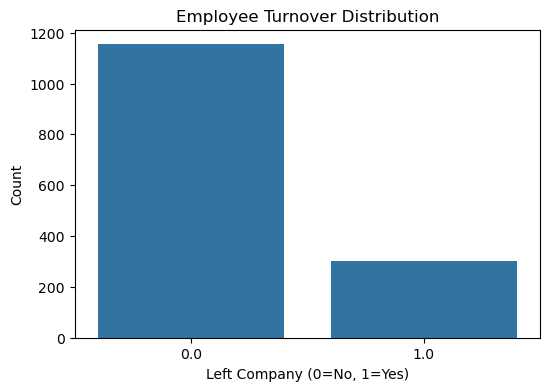

In [6]:
# Visualize the distribution of turnover
plt.figure(figsize=(6, 4))
sns.countplot(x='left', data=df)
plt.title('Employee Turnover Distribution')
plt.xlabel('Left Company (0=No, 1=Yes)')
plt.ylabel('Count')
plt.show()

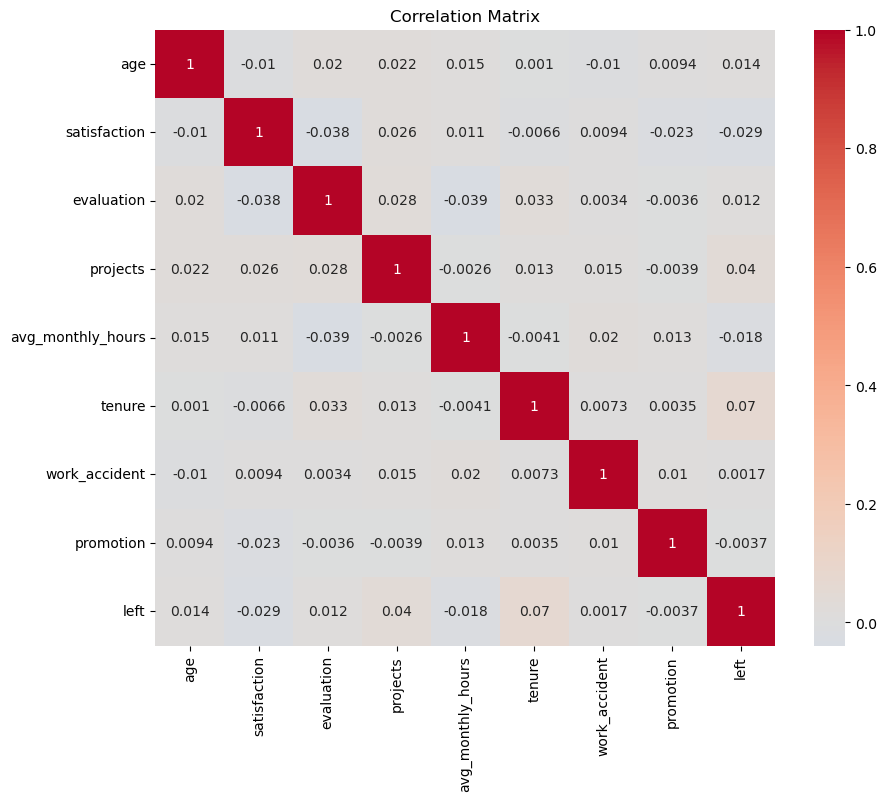

In [7]:
# Correlation matrix
plt.figure(figsize=(10, 8))
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

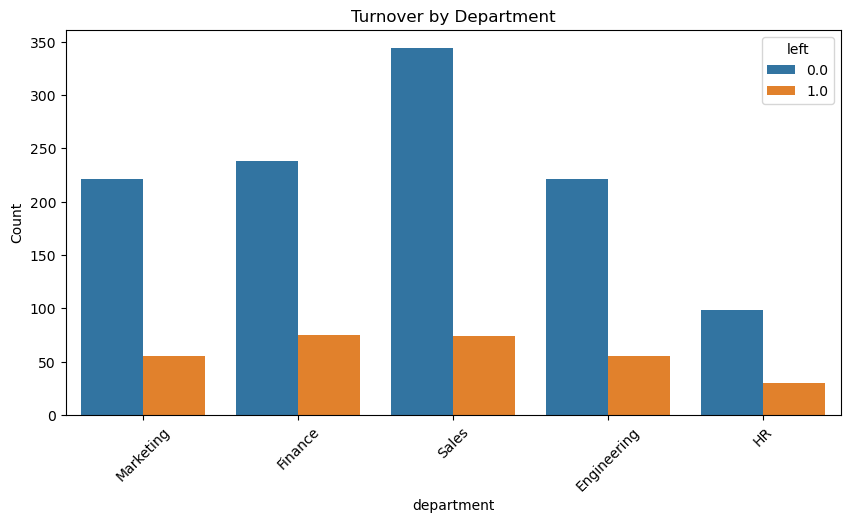

In [8]:
# Analyze turnover by department
plt.figure(figsize=(10, 5))
sns.countplot(x='department', hue='left', data=df)
plt.title('Turnover by Department')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

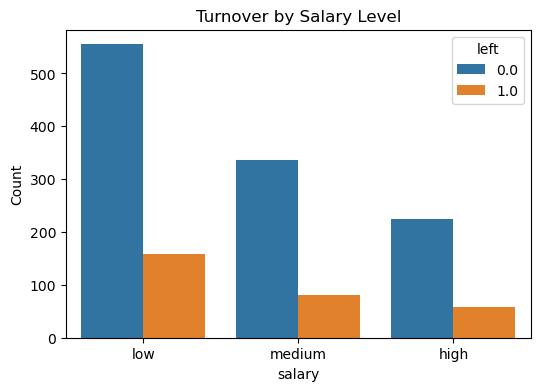

In [9]:
# Analyze turnover by salary level
plt.figure(figsize=(6, 4))
sns.countplot(x='salary', hue='left', data=df, order=['low', 'medium', 'high'])
plt.title('Turnover by Salary Level')
plt.ylabel('Count')
plt.show()

In [10]:
# Handle missing values
# For numerical columns, fill with median
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
for col in num_cols:
    df[col].fillna(df[col].median(), inplace=True)
    
# For categorical columns, fill with mode
cat_cols = df.select_dtypes(include=['object']).columns
for col in cat_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

# Verify no missing values remain
print("Remaining missing values:", df.isnull().sum().sum())

Remaining missing values: 0


In [11]:
# Define features and target
X = df.drop('left', axis=1)
y = df['left']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [12]:
# Preprocessing pipeline
numeric_features = ['age', 'satisfaction', 'evaluation', 'projects', 'avg_monthly_hours', 'tenure']
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_features = ['department', 'salary']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [13]:
# Logistic Regression Model
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42))
])

lr_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'satisfaction',
                                                   'evaluation', 'projects',
                                                   'avg_monthly_hours',
                                                   'tenure']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['department', 'salary'])])),
                ('classifier', LogisticRegression(random_state=42))])

In [14]:
# Random Forest Model
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'satisfaction',
                                                   'evaluation', 'projects',
                                                   'avg_monthly_hours',
                                                   'tenure']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['department', 'salary'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [15]:
def evaluate_model(model, X_test, y_test):
    """Helper function to evaluate model performance"""
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print("ROC AUC Score:", roc_auc_score(y_test, y_proba))
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc_score(y_test, y_proba):.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

Logistic Regression Performance:
Accuracy: 0.8
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
ROC AUC Score: 0.5064506172839507

Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      1.00      0.89       360
         1.0       0.00      0.00      0.00        90

    accuracy                           0.80       450
   macro avg       0.40      0.50      0.44       450
weighted avg       0.64      0.80      0.71       450



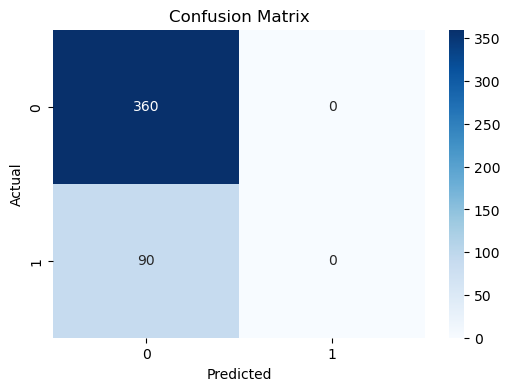

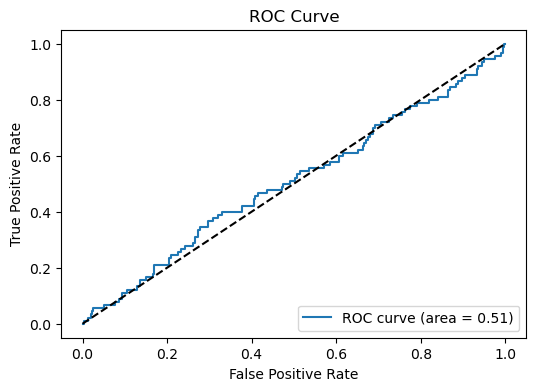

In [16]:
print("Logistic Regression Performance:")
evaluate_model(lr_pipeline, X_test, y_test)

Random Forest Performance:
Accuracy: 0.7955555555555556
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
ROC AUC Score: 0.4943364197530864

Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      0.99      0.89       360
         1.0       0.00      0.00      0.00        90

    accuracy                           0.80       450
   macro avg       0.40      0.50      0.44       450
weighted avg       0.64      0.80      0.71       450



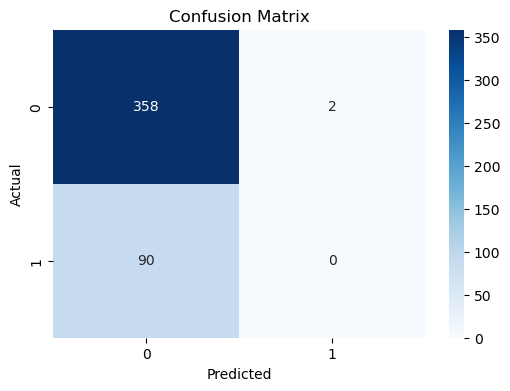

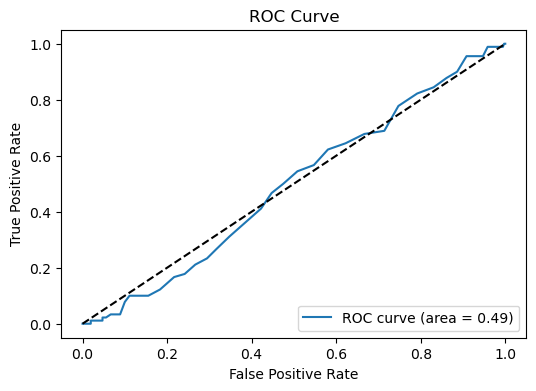

In [17]:
print("Random Forest Performance:")
evaluate_model(rf_pipeline, X_test, y_test)

In [18]:
# Get feature names after one-hot encoding
preprocessor.fit(X_train)
feature_names = (numeric_features + 
                 list(preprocessor.named_transformers_['cat'].named_steps['onehot']
                     .get_feature_names_out(categorical_features)))

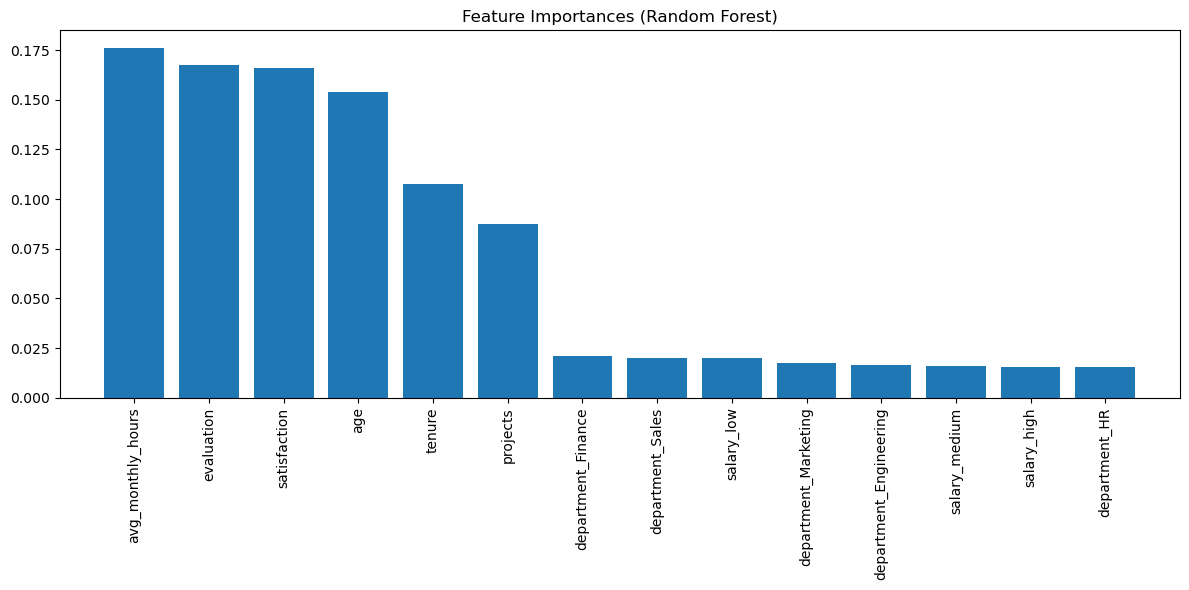

In [19]:
# Plot feature importance for Random Forest
rf_model = rf_pipeline.named_steps['classifier']
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title("Feature Importances (Random Forest)")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
plt.xlim([-1, len(importances)])
plt.tight_layout()
plt.show()

Best parameters: {'classifier__max_depth': 5, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}

Tuned Random Forest Performance:
Accuracy: 0.8
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
ROC AUC Score: 0.5144135802469135

Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      1.00      0.89       360
         1.0       0.00      0.00      0.00        90

    accuracy                           0.80       450
   macro avg       0.40      0.50      0.44       450
weighted avg       0.64      0.80      0.71       450



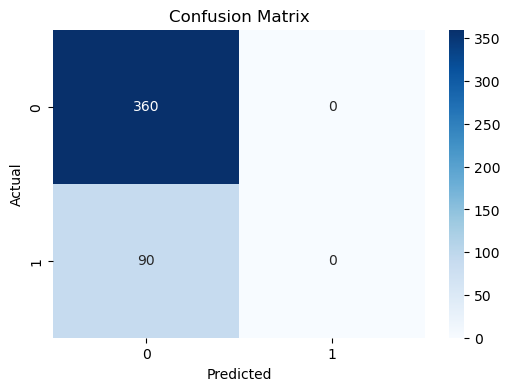

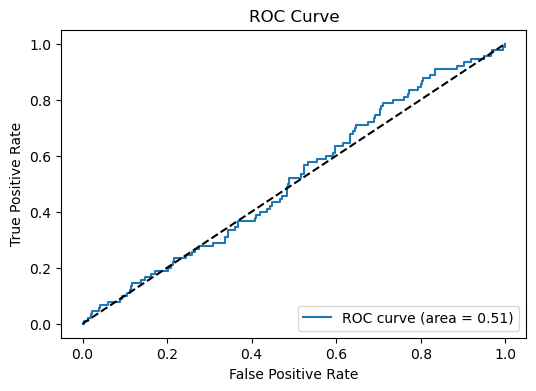

In [20]:
# Tune Random Forest parameters
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 5, 10],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(rf_pipeline, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters
print("Best parameters:", grid_search.best_params_)

# Evaluate tuned model
print("\nTuned Random Forest Performance:")
evaluate_model(grid_search.best_estimator_, X_test, y_test)

In [21]:
# Train final model with best parameters
final_model = grid_search.best_estimator_

In [22]:
# Get probability of turnover for all employees
df['turnover_probability'] = final_model.predict_proba(X)[:, 1]

# Identify high-risk employees (top 10% probability)
high_risk_threshold = df['turnover_probability'].quantile(0.9)
high_risk_employees = df[df['turnover_probability'] >= high_risk_threshold]

print(f"Identified {len(high_risk_employees)} high-risk employees (top 10%)")

Identified 150 high-risk employees (top 10%)


In [23]:
# Analyze characteristics of high-risk employees
print("\nCharacteristics of High-Risk Employees:")
print(high_risk_employees.describe())


Characteristics of High-Risk Employees:
              age  satisfaction  evaluation    projects  avg_monthly_hours  \
count  150.000000    150.000000  150.000000  150.000000         150.000000   
mean    47.753333      0.516733    0.660733    4.733333         223.353333   
std     12.495334      0.273148    0.236377    1.732696          78.684583   
min     22.000000      0.100000    0.300000    1.000000         120.000000   
25%     38.000000      0.312500    0.442500    3.000000         147.000000   
50%     49.000000      0.500000    0.640000    5.000000         198.000000   
75%     59.750000      0.730000    0.940000    6.000000         304.750000   
max     64.000000      1.000000    1.000000    7.000000         349.000000   

           tenure  work_accident   promotion        left  turnover_probability  
count  150.000000     150.000000  150.000000  150.000000            150.000000  
mean     7.420000       0.080000    0.080000    0.660000              0.299969  
std      2.57

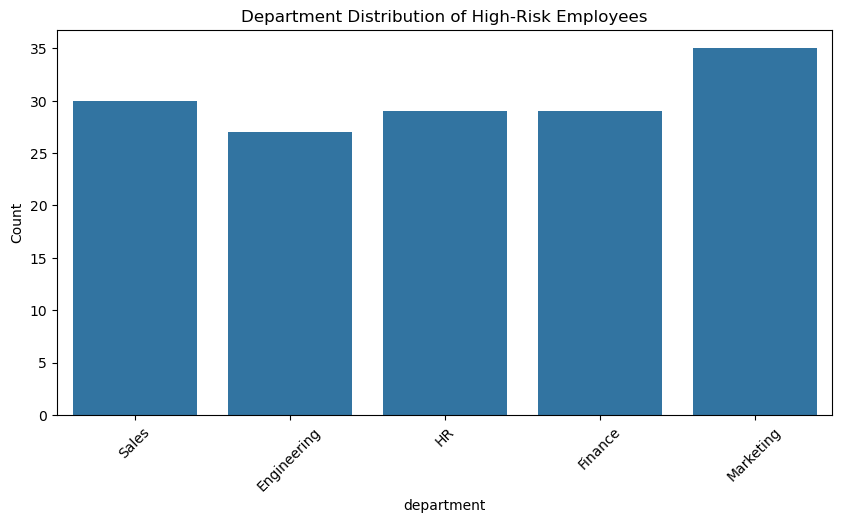

In [24]:
# Department distribution of high-risk employees
plt.figure(figsize=(10, 5))
sns.countplot(x='department', data=high_risk_employees, order=departments)
plt.title('Department Distribution of High-Risk Employees')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

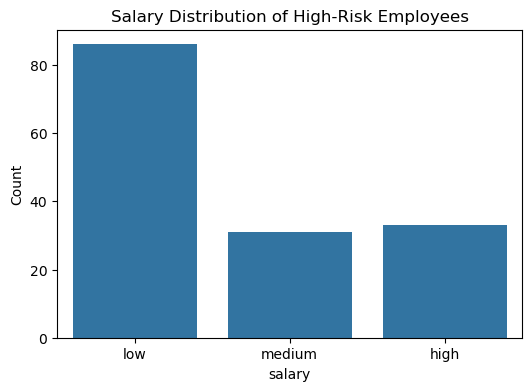

In [25]:
# Salary distribution of high-risk employees
plt.figure(figsize=(6, 4))
sns.countplot(x='salary', data=high_risk_employees, order=['low', 'medium', 'high'])
plt.title('Salary Distribution of High-Risk Employees')
plt.ylabel('Count')
plt.show()